In [1]:
%pip install scikit-learn
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler


# para medir cuanto tiempo se demora ejecutando el código
import time
start_time = time.time()

 tamaño normal: 19911
 tamaño anómala: 8782


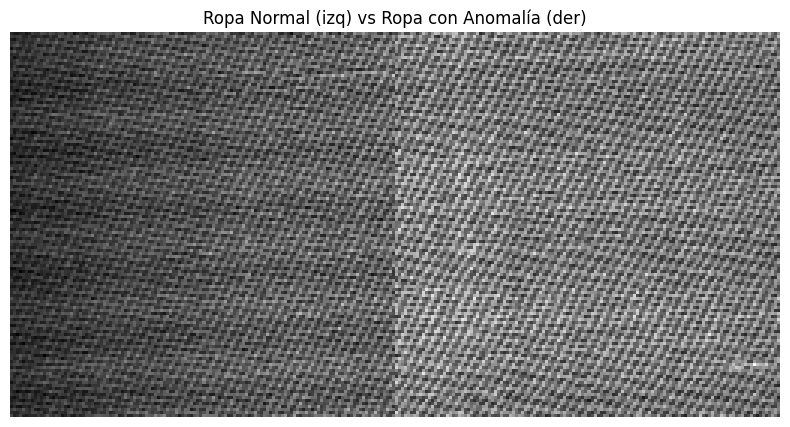

In [3]:
# =====================
# 2. Cargar imágenes y etiquetas
# =====================
def cargar_imagenes(path, etiqueta, size=(128,128)):
    X, y = [], []
    for archivo in os.listdir(path):
        img = cv2.imread(os.path.join(path, archivo), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, size)
            X.append(img)
            y.append(etiqueta)
    return X, y

ropa_normal, y_normal = cargar_imagenes("./ropa_normal", 0)
ropa_anomalia, y_anomalia = cargar_imagenes("./ropa_anormal", 1)
 
print(f" tamaño normal: {len(ropa_normal)}")
print(f" tamaño anómala: {len(ropa_anomalia)}")


## visualizamos una imagen de cada dataset
comparacion = np.hstack((ropa_normal[0], ropa_anomalia[16]))

# Mostramos la comparación
plt.figure(figsize=(10, 5))
plt.imshow(comparacion, cmap='gray')
plt.title("Ropa Normal (izq) vs Ropa con Anomalía (der)")
plt.axis("off")
plt.show()


note que tenemos muy poca imágenes de ropa defectuosa por lo que hacemos un aumento de datos (note que tenemos especial cuidado con al hacerle las transformaciones no se pierda la anomalía): 



In [4]:
# Data augmentaion -> para las de categoría 1(ropa anomala)

def augmentar_imagen(img):
    filas, cols = img.shape[:2]
    img_aug = img.copy()

    # Rotación aleatoria (±15°)
    if np.random.rand() > 0.5:
        M_rot = cv2.getRotationMatrix2D((cols / 2, filas / 2), np.random.uniform(-15, 15), 1)
        img_aug = cv2.warpAffine(img_aug, M_rot, (cols, filas), borderMode=cv2.BORDER_REFLECT)

    # Traslación aleatoria (±5 píxeles)
    if np.random.rand() > 0.5:
        dx, dy = np.random.randint(-5, 6, 2)
        M_trans = np.float32([[1, 0, dx], [0, 1, dy]])
        img_aug = cv2.warpAffine(img_aug, M_trans, (cols, filas), borderMode=cv2.BORDER_REFLECT)

    # Flip horizontal aleatorio
    if np.random.rand() > 0.5:
        img_aug = cv2.flip(img_aug, 1)

    # Flip vertical aleatorio
    if np.random.rand() > 0.5:
        img_aug = cv2.flip(img_aug, 0)

    return img_aug


# Duplicar imágenes anómalas con aumentaciones suaves
ropa_anomalia_aug = []
for img in ropa_anomalia:
    for _ in range(1):  # Duplicamos anomalías
        ropa_anomalia_aug.append(augmentar_imagen(img))

y_anomalia_aug = [1] * len(ropa_anomalia_aug)

print(f" tamaño normal: {len(ropa_normal)}")
print(f" tamaño anómala: {len(ropa_anomalia)+ len(ropa_anomalia_aug)}")


# Reunimos todo el dataset balanceado
X = ropa_normal + ropa_anomalia + ropa_anomalia_aug
y = y_normal + y_anomalia + y_anomalia_aug





 tamaño normal: 19911
 tamaño anómala: 17564


## Preprocesar la Imagen
note que debido a que queremos detectar anomalías dentro de la ropa, realizar detección de bordes puede eliminar esas pequeñas imperfecciones que justamente queremos detectar por lo que solo realizamos la equalizacion con el objetivo de aumentar el contraste

sin embargo averiguaremos con métricas si es mejor solo equalizar o ecualizar y aplicar filtros de suavizado

# 1. Funciones de preprocesamiento
def solo_ecualizacion(img):
    imf=  cv2.equalizeHist(img)
    # Aplicamos suavizado previo para reducir ruido
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Aplicamos Canny con umbrales bajos
    edges = cv2.Canny(img_blur, threshold1=30, threshold2=60)

    return edges



# # 2. Aplicar ambos preprocesamientos
X_proc_eq = [solo_ecualizacion(img) for img in X]



## Aplicacióon de SIFT y creación de BoVW

Note que esto lo ahremos con el mejor modelo de los dos anteriores, en este caso fue con equalizado+sobel


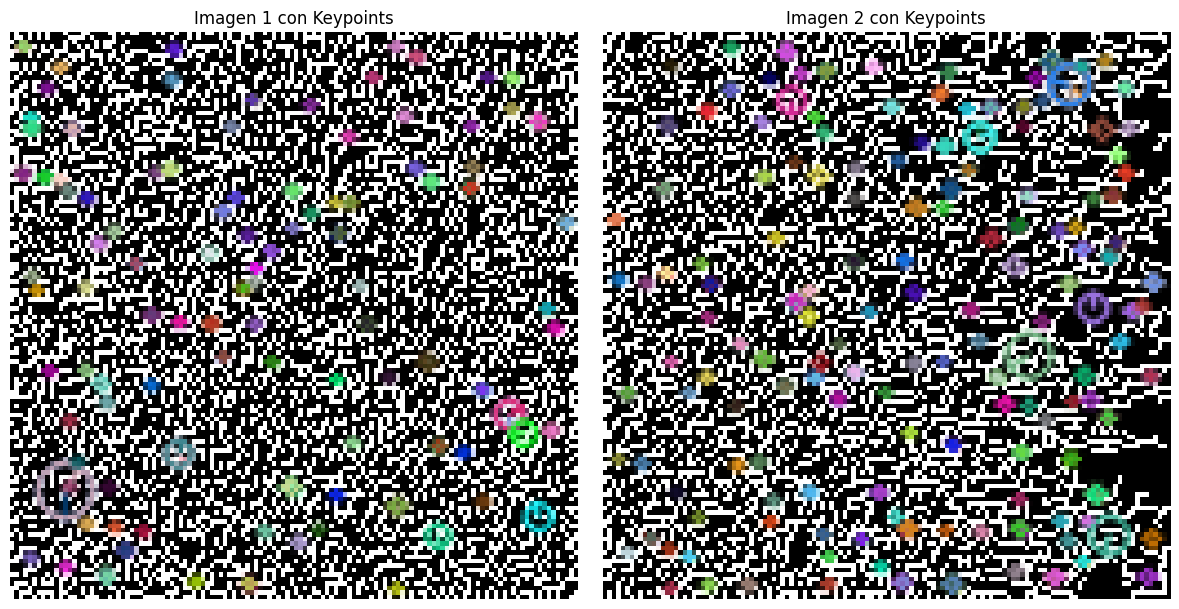

In [7]:
# =====================
# 4. Extracción de características (SIFT + BoVW)
# =====================
sift = cv2.SIFT_create()
all_descriptors = []
for img in X_proc_eq:
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        all_descriptors.extend(des.astype(np.float32))

all_descriptors = np.array(all_descriptors, dtype=np.float32)
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(all_descriptors)

def construir_histograma(img):
    kp, des = sift.detectAndCompute(img, None)
    hist = np.zeros(50)
    if des is not None:
        des = des.astype(np.float32)
        pred = kmeans.predict(des)
        for p in pred:
            hist[p] += 1
    return hist

X_features = np.array([construir_histograma(img) for img in X_proc_eq])

## visualizamos la detección de caracteristicas en dos imágenes de X_proc
imgs = [X_proc_eq[16], X_proc_eq[18]]

# Dibuja keypoints para ambas
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, img in enumerate(imgs):
    kp = sift.detect(img, None)
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axs[i].imshow(img_kp, cmap='gray')
    axs[i].set_title(f'Imagen {i+1} con Keypoints')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Machine learning
usamos nuestra BoVW (X_features) para entrenar un modelo de Machine learning con los siguientes pasos:
* Transformaciones de datos -> realizado en pasos anteriores
* Selección de características -> realizado en pasos anteriores
* Entrenamiento de clasificador (Random Forest)
* Evaluación y Métricas.

Note que usamos `RandomForestClassifier`  ya que es una **elección sólida** para un pipeline con BoVW porque:

- Se adapta naturalmente al tipo de datos generados.
- Tiene buen desempeño sin necesidad de ajustes complicados.
- Es estable, rápido y fácil de interpretar.


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.79      0.68      3986
           1       0.62      0.39      0.48      3509

    accuracy                           0.60      7495
   macro avg       0.61      0.59      0.58      7495
weighted avg       0.61      0.60      0.58      7495

Matriz de confusión:
 [[3157  829]
 [2157 1352]]


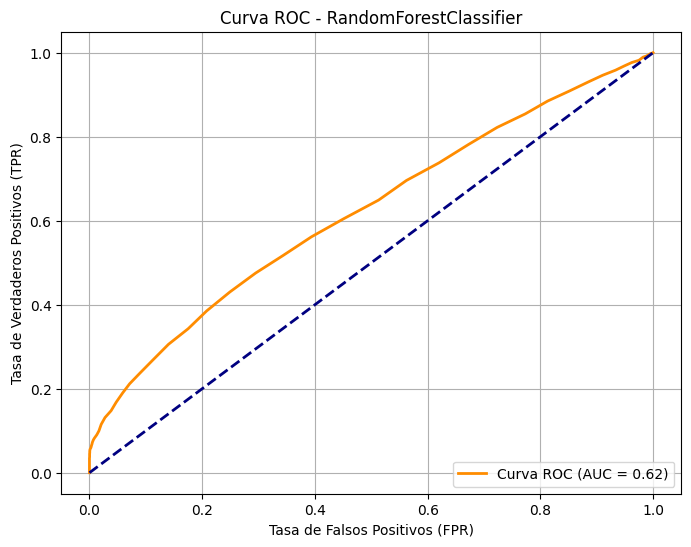

In [8]:
# =====================
# 5. Pipeline con RandomForest normal
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42, class_weight='balanced')) 
])

pipe.fit(X_train, y_train)

# =====================
# 6. Resultados
# =====================
y_pred = pipe.predict(X_test)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))




# Obtener probabilidades de clase positiva
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1 (anómala)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - RandomForestClassifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### mejorando hyperparametros

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Mejores parámetros: {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.76      0.67      3986
           1       0.60      0.41      0.49      3509

    accuracy                           0.60      7495
   macro avg       0.60      0.59      0.58      7495
weighted avg       0.60      0.60      0.58      7495

Matriz de confusión:
 [[3037  949]
 [2075 1434]]


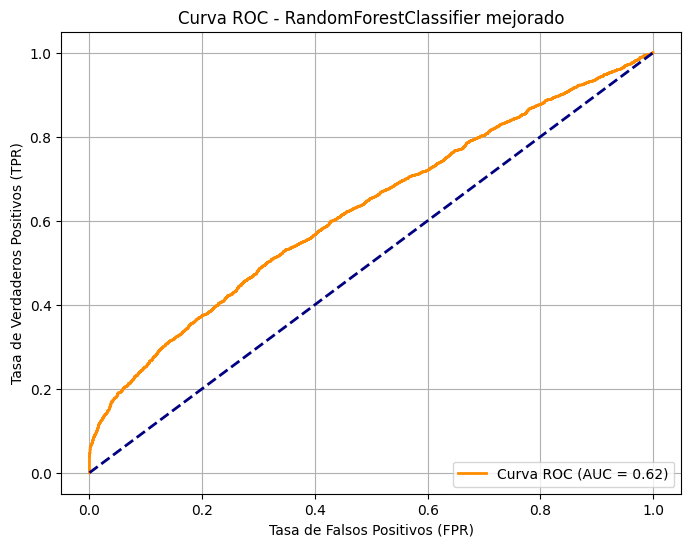

In [9]:
# =====================
# 5. Pipeline con RandomForest y GridSearch (ampliado)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    "clf__n_estimators": [50, 100, 150, 200],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# =====================
# 6. Resultados y curva ROC
# =====================
y_pred = grid.predict(X_test)



print("Mejores parámetros:", grid.best_params_)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))




# Obtener probabilidades de clase positiva
y_prob = grid.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1 (anómala)

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - RandomForestClassifier mejorado')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [10]:


# =====================
# 7. Metricas del notebook
# =====================

end_time = time.time()
total_time = end_time - start_time

mins, secs = divmod(total_time, 60)
print(f"⏱️ Tiempo total de ejecución: {int(mins)} minutos y {secs:.2f} segundos")

⏱️ Tiempo total de ejecución: 34 minutos y 25.77 segundos
